In [1]:
from sklearn.datasets import fetch_20newsgroups

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

documents = newsgroups.data

In [5]:
### Text Preprocessing

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Remove non-alphabetical characters and lowercase the text
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    # Tokenize and lemmatize
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to each document
cleaned_documents = [preprocess(doc) for doc in documents]

# Convert documents to a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(documents)

In [6]:
### Topic Modeling with LDA

In [4]:
import gensim
from gensim import corpora

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary([doc.split() for doc in cleaned_documents])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Convert the corpus into a bag-of-words format
corpus = [dictionary.doc2bow(doc.split()) for doc in cleaned_documents]

# Apply LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print the topics discovered by LDA
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.216*"ax" + 0.043*"q" + 0.038*"p" + 0.037*"f" + 0.036*"w"')
(1, '0.019*"edu" + 0.015*"image" + 0.009*"mail" + 0.008*"com" + 0.008*"information"')
(2, '0.010*"government" + 0.009*"state" + 0.007*"gun" + 0.007*"armenian" + 0.007*"people"')
(3, '0.014*"one" + 0.010*"year" + 0.010*"get" + 0.010*"time" + 0.009*"go"')
(4, '0.041*"x" + 0.021*"window" + 0.020*"file" + 0.012*"do" + 0.011*"program"')
(5, '0.014*"drive" + 0.011*"card" + 0.009*"one" + 0.008*"would" + 0.008*"disk"')
(6, '0.037*"game" + 0.025*"team" + 0.015*"player" + 0.011*"season" + 0.011*"play"')
(7, '0.015*"would" + 0.012*"people" + 0.012*"one" + 0.010*"think" + 0.008*"know"')
(8, '0.036*"god" + 0.017*"key" + 0.011*"jesus" + 0.011*"christian" + 0.010*"church"')
(9, '0.007*"car" + 0.006*"use" + 0.006*"year" + 0.005*"one" + 0.005*"new"')


In [8]:
### Visualization of Topics

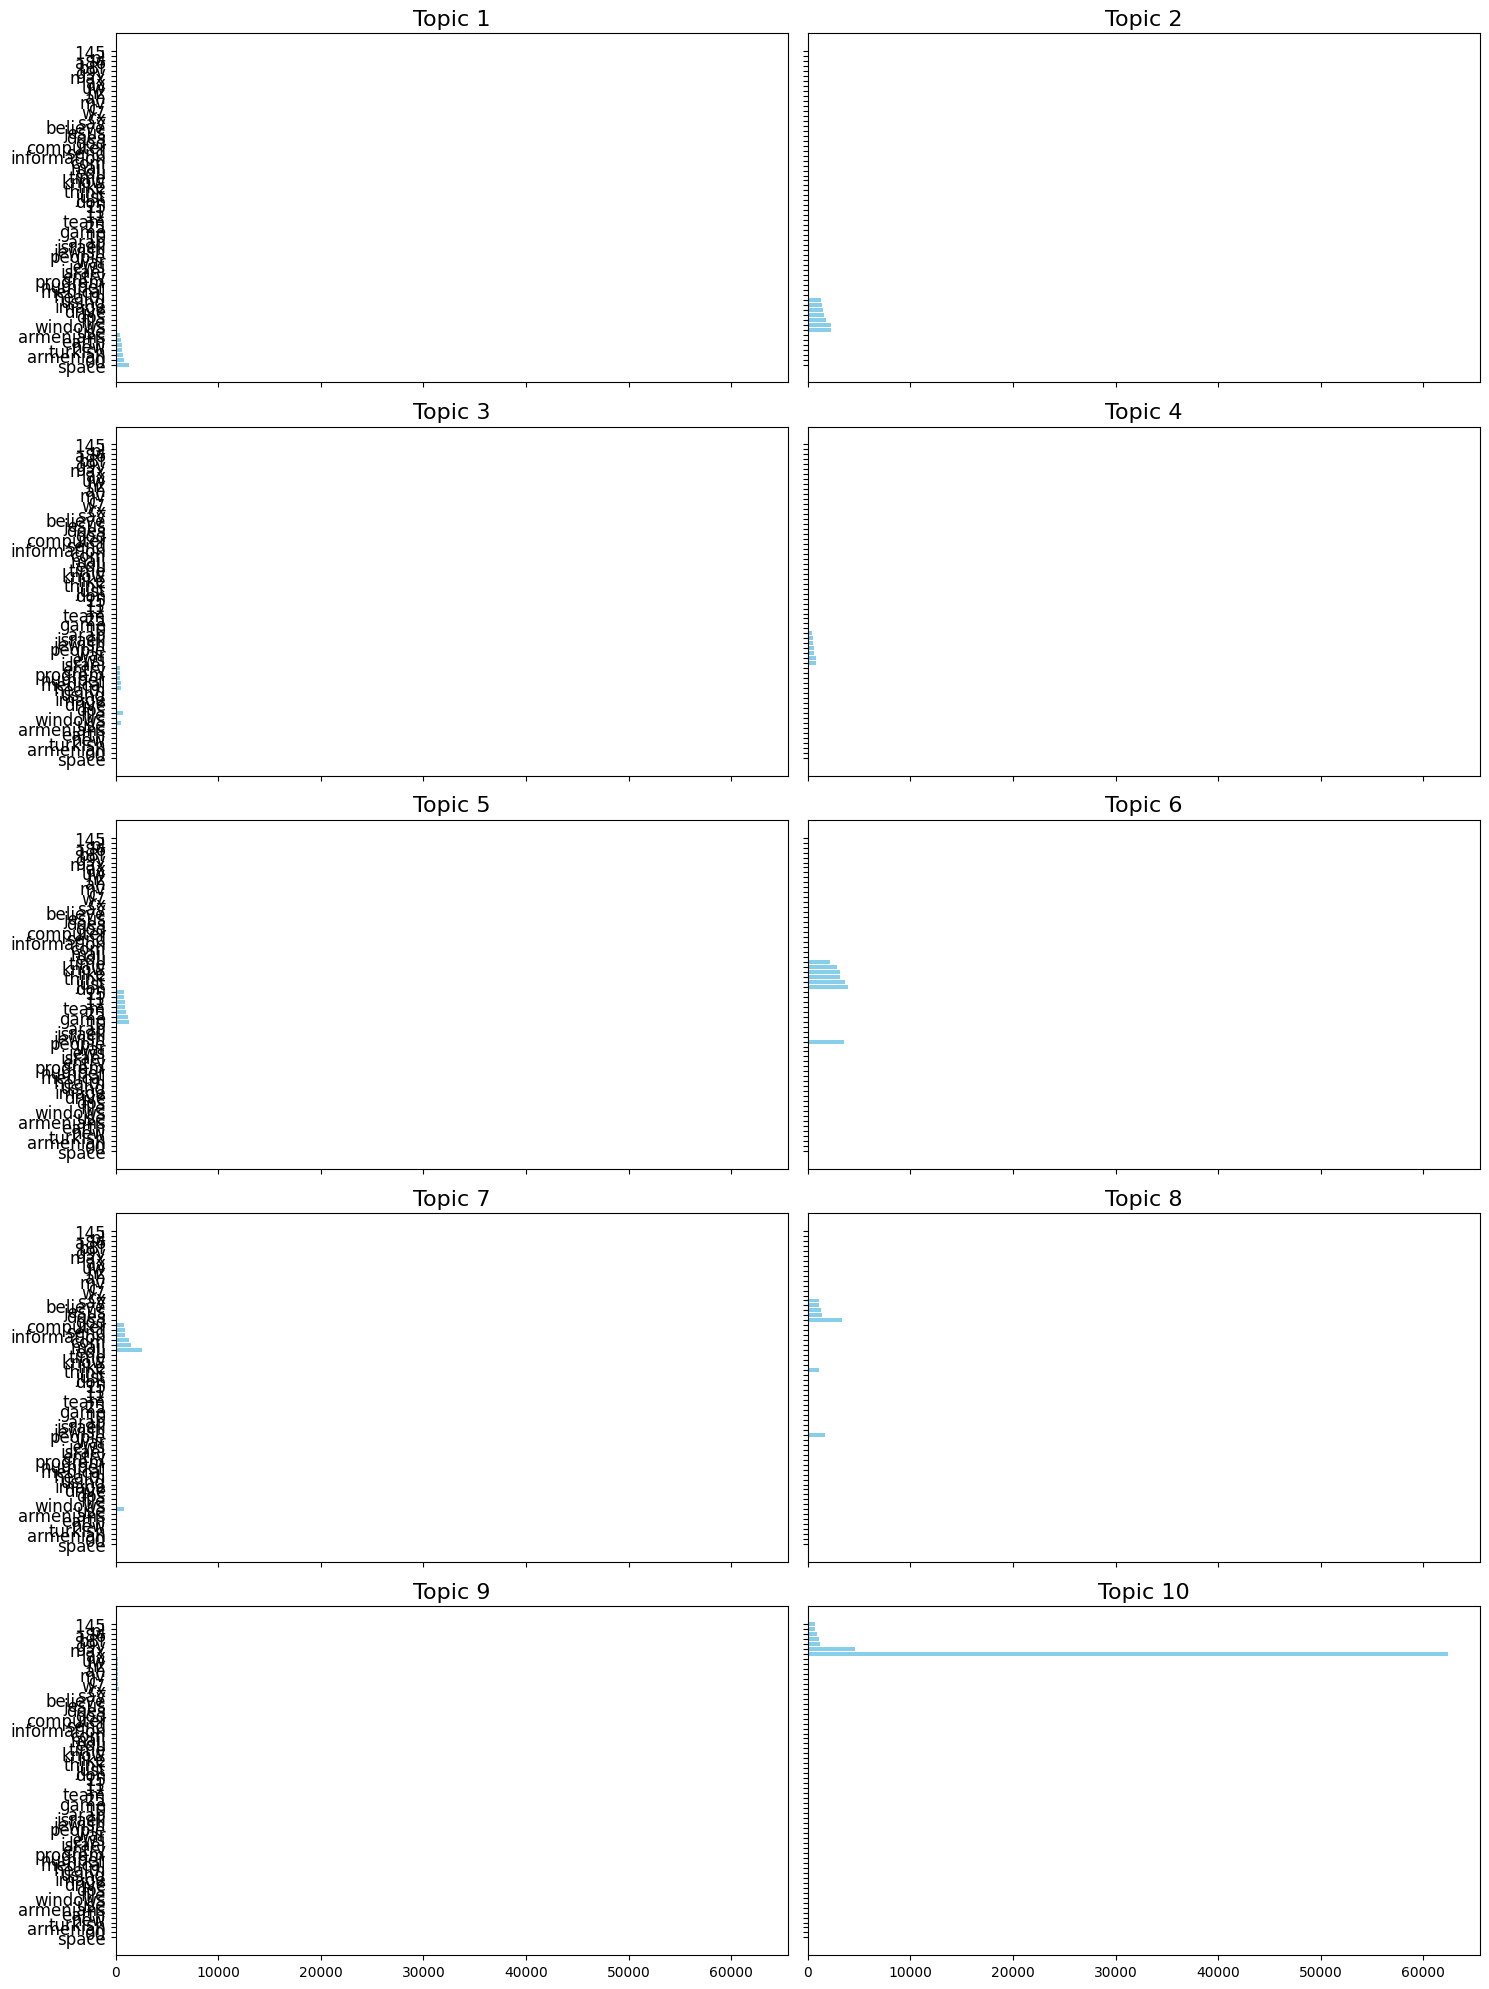

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Create the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(doc_term_matrix)

# Extract feature names (terms)
terms = vectorizer.get_feature_names_out()

# Plot the top words per topic with improved display
num_topics = lda.components_.shape[0]
words_per_topic = 7  # Show only the top 7 words per topic
cols = 2  # Number of columns in the figure
rows = (num_topics // cols) + (num_topics % cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_topics:
        top_words = lda.components_[i].argsort()[:-words_per_topic-1:-1]
        topic_words = [terms[idx] for idx in top_words]
        ax.barh(topic_words, lda.components_[i][top_words], color='skyblue')
        ax.set_title(f'Topic {i + 1}', fontsize=16)
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=10)
    else:
        ax.axis('off')  # Hide any unused subplots

plt.tight_layout()
plt.show()

In [15]:
### Document Similarity with Word Embeddings

In [18]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=[doc.split() for doc in cleaned_documents], vector_size=100, window=5, min_count=5, workers=4)

# Generate document vectors by averaging word vectors
def document_vector(doc):
    words = [word for word in doc.split() if word in word2vec_model.wv]
    if words:  # Check if there are any valid words
        return sum(word2vec_model.wv[word] for word in words) / len(words)
    else:
        return None  # Return None or skip this document

# Apply the function to each document
doc_vectors = [document_vector(doc) for doc in cleaned_documents if document_vector(doc) is not None]

# Calculate cosine similarity between documents
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(doc_vectors)

# Print similarity matrix for first 5 documents
print(similarity_matrix[:5, :5])

[[0.99999994 0.4754893  0.6271292  0.34201115 0.45100918]
 [0.4754893  1.0000002  0.18054685 0.8145625  0.7796868 ]
 [0.6271292  0.18054685 1.         0.2210788  0.32414415]
 [0.34201115 0.8145625  0.2210788  0.9999998  0.84654456]
 [0.45100918 0.7796868  0.32414415 0.84654456 1.        ]]
